In [1]:
# Dataset information:

from IPython.display import IFrame
IFrame("data/Guide on Data (Rev1,feb6.23) Jeremy Zhao.pdf", width=500, height=400)

In [2]:
# Some python libraries that you might need installing

# conda install --channel conda-forge geopandas
# pip install geopandas
# pip install folium

In [3]:
# imports 

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster, HeatMap, TimestampedGeoJson
import plotly.express as px
import plotly.graph_objects as go


import missingno as msno

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 30

In [4]:
source = pd.read_csv('data/source_list_2019-2022 Jeremy Zhao.csv', index_col=0)  
permian_plume = pd.read_csv('data/permian_plume_list_2019 Jeremy Zhao.csv', index_col=0)  
permian_source = pd.read_csv('data/permian_source_list_2019 Jeremy Zhao.csv', index_col=0) 
plume_attr = pd.read_csv('data/plume_attribution_2019-2022 Jeremy Zhao.csv', index_col=0) 

datasets = [source, permian_plume, permian_source, plume_attr]

for i in datasets:
    print(i.shape)

(4199, 9)
(3067, 10)
(1756, 10)
(8752, 12)


In [5]:
plume_attr.columns

Index(['source_id', 'candidate_id', 'plume_lat', 'plume_lon', 'date',
       'source_type', 'ipcc', 'qplume', 'sigma_qplume', 'time_of_detection',
       'plume_tif', 'rgb_tif'],
      dtype='object')

# I. Data Explorations and Dataset Understanding

#### A. source_list_2019-2022 dataset

#### From what locations and emissions is dataset situated?

Most of the source are concentrated at the permian basin. colorado and california has more than 400 entries in the dataset.

Most of the average source emissions (units in kg/hr) are in the Permian Basin.

#### What source_type has the most emissions?

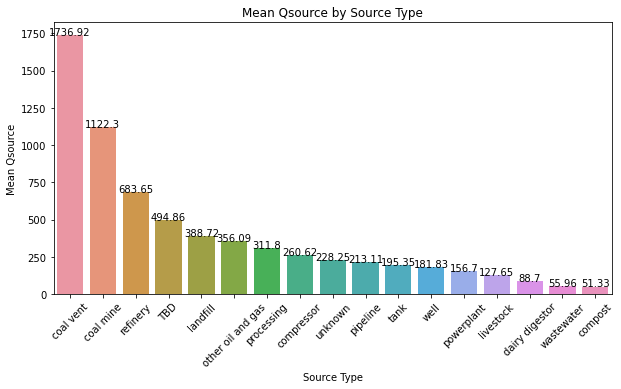

In [6]:
plt.figure(figsize=(10,5))

agg_df = source.groupby("source_type")["qsource"].mean().reset_index().sort_values(by='qsource', ascending=False)

sns.barplot(x=agg_df["source_type"], y=agg_df["qsource"])

for i, v in enumerate(agg_df["qsource"]):
    plt.text(i, v, str(round(v, 2)), ha='center')

plt.title("Mean Qsource by Source Type")
plt.xlabel("Source Type")
plt.ylabel("Mean Qsource")
plt.xticks(rotation=45)

plt.show()

From the data, it appears that the "coal vent" source type has the highest average "qsource" value of 1736.9175, followed by the "coal mine" source type with an average "qsource" value of 1122.3045. The "refinery" source type has the third highest average "qsource" value of 683.6538.

It's important to note that this is only a snapshot of the data, and further analysis and context may be necessary to fully understand the implications of these values.

#### See relationships and correlations

In [7]:
# sns.pairplot(df)

No correlation patterns except for qplume/qsource and sigma. This is self explanatory because emission estimations are derived from sigmas. 

# Merging all the dataset

In [8]:
# assign dfs to manage coding

df1 = source
df2 = permian_plume
df3 = permian_source
df4 = plume_attr

In [9]:
# merge df1 and df4 on source_id

merged_df = pd.merge(df1, df4, on='source_id')
merged_df.columns = merged_df.columns.str.rstrip('_x') 
merged_df = merged_df.drop(columns=('source_type_y'))

# check df counts to see how many data point can capture

In [10]:
# merge df2 and df3 which are the permian specific dataset

merged_per = pd.merge(df2, df3, on='source_id')
merged_per.columns = merged_per.columns.str.rstrip('_x') 

Only 3067 remain in the dataset when merging all four datasets <br>

The columns extracted are:<br>

'source_id'                   = unique identifier of the source<br>
'source_lat', 'source_lon'    = geo data to locate emissions<br>
'number_overflights'          = number of overhead flights<br>
'source_persistence'          = frequency of the observation (number of detected plumesdivided by number of observations)<br>
'qsource'                     = Persistence adjusted average source emissions (units in kg/hr)<br>
'sigma_qsource'               = the +/- of the qsource (units in kg/hr)<br>
'source_type'                 = tank, well, compressor<br>
'confidence_in_persistence'   = cat value of category_in_persistence_num<br>
'candidate_id'                = unique identifier with sat, timestamp and flight path<br>
'plume_lat', 'plume_lon'      = location of the plume<br>
'date'                        = date<br>
'ipcc'                        = the IPCC sector the source/plume falls into<br>
'qplume'                      = concentration of a particular pollutant, the size of the plume, or the direction of plume dispersion. In this case, the "qplume" column could be a likely target variable.<br>
'sigma_qplume'                = the +/- of the qplume (units in kg/hr)<br>
'time_of_detection'           = Time of detection <br>
'active_flair_detected', 'inactive_flair_detected' = if there's flare or not<br>
'confidence_in_persistence_num' = (f = M/N) in which a plume was detected, where M is the number of detected plumes at that source location during the campaign and N is the number of overflights over <br>
'satellite'                   = GAO or AVIRIS NG<br>
'timestamp'                   = timestamp code of the observation<br>
'flight_path'                 = flight path grouping <br>

check dates of the two merged datasets and compare their timestamps

merged_df is the main dataset the also includes that of the separated permian dataset.
In this case we will be only be working on merged_df

#### Code below is to check how many rows will permian dataset will match the source dataset.

In [11]:
# selected_rows = [pd.concat([row1, row2], axis=0) for _, row1 in merged_df.iterrows() 
#                  for _, row2 in merged_per.iterrows() 
#                  if (row1['source_id'] == row2['source_id']) and (row1['candidate_id'] == row2['candidate_id'])]

# if len(selected_rows) > 0:
#     selected_df = pd.concat(selected_rows, axis=1).T
#     print(selected_df)
# else:
#     print("No rows with matching values in source_id and candidate_id columns were found.")

In [12]:
# Extracting data from candidate_id

merged_df['satellite'] = merged_df['candidate_id'].str[:3]
merged_df['timestamp'] = merged_df['candidate_id'].str[3:17]
merged_df['flight_path'] = merged_df['candidate_id'].str[:3] +'-'+ merged_df['candidate_id'].str[-1]

In [13]:
merged_df['time'] = merged_df['timestamp'].str.slice(9).astype(int)

In [14]:
# convert the time component to a timedelta object
td = pd.to_timedelta(merged_df['time'], unit='s')

# extract the time component from the timedelta object
merged_df['time'] = td.dt.components['hours'].astype(str).str.zfill(2) + ':' + td.dt.components['minutes'].astype(str).str.zfill(2) + ':' + td.dt.components['seconds'].astype(str).str.zfill(2)

In [15]:
# combine date and time columns into a single datetime column
merged_per["datetime2"] = pd.to_datetime(merged_per["date"] + " " + merged_per["time"])
merged_df["datetime"] = pd.to_datetime(merged_df["date"] + " " + merged_df["time"])

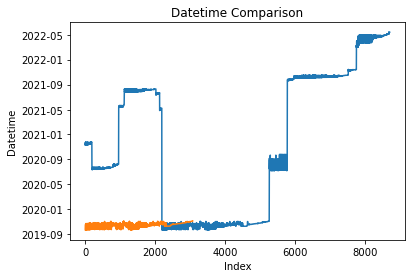

In [16]:
# plot the datetime column from merged_df
plt.plot(merged_df["datetime"])

# plot the datetime2 column from merged_per
plt.plot(merged_per["datetime2"])

# set the plot title and axis labels
plt.title("Datetime Comparison")
plt.xlabel("Index")
plt.ylabel("Datetime")

# display the plot
plt.show()

#### clean more the df 

In [17]:
# drop all columns that we don't need

cols = ['time_of_detection', 'plume_tif', 'rgb_tif']
merged_df = merged_df.drop(columns=cols)

In [18]:
# clean ipcc to look better

merged_df['ipcc'] = merged_df['ipcc'].replace({'1B2 Oil & Natural Gas':'Oil & Natural Gas',
                           '1A1 Energy Industries':'Energy Industries',
                           '6A Solid Waste Disposal On Land':'Solid Waste Disposal On Land',
                           '3A2 Manure Management':'Manure Management',
                           '1B1a Coal Mining':'Coal Mining',
                           '1A1b Petroleum Refining':'Petroleum Refining',
                           '4D1 Domestic Wastewater Treatment & Discharge':'Domestic Wastewater Treatment & Discharge',
                           '4D2 Industrial Wastewater Treatment & Discharge':'Industrial Wastewater Treatment & Discharge',})

In [19]:
# just to for easy reference to the code 
df = merged_df  

In [20]:
# dataframe that has no nans
df_ = df.dropna()

# II. Exploratory Data Analysis of the merged_df

#### Which flight path have detected methane emissions?

<AxesSubplot:xlabel='sigma_qplume'>

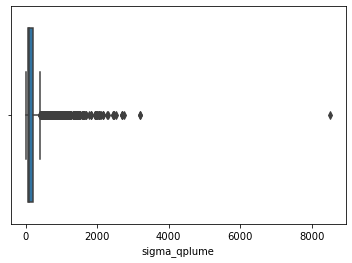

In [21]:
sns.boxplot(data=df_, x=df['sigma_qplume'])

In [22]:
# how many flight paths?
df['flight_path'].nunique()

64

In [23]:
import plotly.express as px

# create a copy of the DataFrame
df_c = df.copy()

# convert datetime column to string format
df_c['datetime'] = df_c['datetime'].astype(str)

# add year column for better visualization
df_c['year'] = df_c['datetime'].str.slice(stop=4)

# create the figure
fig = px.line_mapbox(df_c, lat="plume_lat", lon="plume_lon", color="flight_path",
                     zoom=3, height=500, hover_name="flight_path",
                     hover_data={"flight_path": False, "plume_lat": True, "plume_lon": True, "datetime": True},
                     mapbox_style="open-street-map", title="Flight Path per Date Time",
                     animation_frame='datetime')

# update animation settings
fig.update_layout(
    updatemenus=[],
    sliders=[],
    mapbox={'center': {'lon': -115, 'lat': 37}, 'style': "open-street-map"}
)

fig.show()


KeyboardInterrupt: 

In [ ]:
# convert datetime column to datetime object
df_c['datetime'] = pd.to_datetime(df_c['datetime'])

# create a new column for month and year
df_c['month'] = df_c['datetime'].dt.month
df_c['year'] = df_c['datetime'].dt.year.astype(str)
df_c = df_c.sort_values(by='datetime')

# set up the figure with a slider
fig = px.line_mapbox(df_c, lat="plume_lat", lon="plume_lon", color="flight_path",
                     zoom=3, height=500, hover_name="flight_path",
                     hover_data={"flight_path": False, "plume_lat": True, "plume_lon": True, "datetime": True},
                     mapbox_style="open-street-map", title="Flight Path per Date Time",
                     animation_frame='month')

# update slider label
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 500, "redraw": True},
                                     "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "<-",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 500, "redraw": True},
                                       "mode": "immediate",
                                       "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                },
                {
                    "args": [{"frame": {"duration": 500, "redraw": True},
                              "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "->",
                    "method": "animate"
                }
            ],
            "pad": {"r": 10, "t": 10},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "y": 0,
            "xanchor": "right",
            "yanchor": "top"
        }
    ],
    sliders=[{
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Year: ",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 500, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [{
            "label": f"{year}-{str(month).zfill(2)}",
            "method": "animate",
            "args": [[month], {"frame": {"duration": 500, "redraw": True},
                               "transition": {"duration": 0}}]
        } for year in df_c['year'].unique() for month in range(1, 13)]
    }]
)

fig.show()


In [ ]:

order = df['flight_path'].value_counts().sort_values(ascending=False).index
fig = px.histogram(df, y='flight_path', category_orders={'flight_path': order})
fig.update_layout(height=500, width=800, title='Flight Path Count')
fig.show()

What's the persistence per source type?

In [ ]:
order = df.groupby('source_type')['source_persistence'].mean().sort_values(ascending=False).index

plt.figure(figsize=(20,8))
sns.barplot(data=df, x='source_type', y='source_persistence', order=order, ci=None);


Based on the visualization, it appears that coal vents are very persistent on emissions which is an outlier, other source types have are relatively gradual decrease.  

#### What's the plume rate per source type?

In [ ]:
order = df.groupby('source_type')['qplume'].mean().sort_values(ascending=False).index

sns.barplot(data=df, y='source_type', x='qplume', order=order, ci=None)

How about persistence per sector?

In [ ]:
order = df.groupby('ipcc')['source_persistence'].mean().sort_values(ascending=False).index

sns.barplot(data=df, y='ipcc', x='source_persistence', order=order, ci=None)

In [ ]:
# how many each satelites observe
df.satellite.value_counts()

#### See persistence on source types and ipcc sector

In [ ]:
plt.figure(figsize=(15,10))

agg_df = df.groupby("source_type")["qplume"].mean().reset_index().sort_values(by='qplume', ascending=False)

sns.boxplot(x=df["source_type"], y=df["qplume"])

for i, v in enumerate(agg_df["qplume"]):
    plt.text(i, v, str(round(v, 2)), ha='center')

plt.title("Mean Qplume by Source Type")
plt.xlabel("Source Type")
plt.ylabel("Mean Qplume")
plt.xticks(rotation=45)

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

agg_df = df.groupby("source_type")["qplume"].mean().reset_index().sort_values(by='qplume', ascending=False)

sns.boxplot(x=df["source_type"], y=df["qplume"])

for i, v in enumerate(agg_df["qplume"]):
    plt.text(i, v, str(round(v, 2)), ha='center')

plt.title("Mean Qplume by Source Type")
plt.xlabel("Source Type")
plt.ylabel("Mean Qplume")
plt.xticks(rotation=45)

plt.show()

In [ ]:
plt.figure(figsize=(15,10))

agg_df = df.groupby("ipcc")["qplume"].mean().reset_index().sort_values(by='qplume', ascending=False)

sns.boxplot(x=df["ipcc"], y=df["qplume"])

for i, v in enumerate(agg_df["qplume"]):
    plt.text(i, v, str(round(v, 2)), ha='center')

plt.title("Mean Qplume by Sector")
plt.xlabel("Sector")
plt.ylabel("Mean Qplume")
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Convert ipcc values to categorical type with ordered categories
ipcc_categories = df_.groupby("ipcc")["qplume"].mean().sort_values(ascending=False).index
df_["ipcc"] = pd.Categorical(df_["ipcc"], categories=ipcc_categories, ordered=True)

# Calculate mean Qplume without outliers by ipcc
qplume_no_outliers = []
for ipcc in df_["ipcc"].unique():
    qplume_sector = df_[df_["ipcc"] == ipcc]["qplume"]
    qplume_no_outliers.append(qplume_sector[~qplume_sector.isin(qplume_sector.quantile([0.25, 0.75]).values)])

# Create a DataFrame with mean Qplume values for each ipcc
agg_df = pd.DataFrame({"ipcc": df_["ipcc"].unique(), "qplume": [q.mean() for q in qplume_no_outliers]})

# Sort the DataFrame by mean Qplume values
agg_df = agg_df.sort_values(by="qplume", ascending=False)

# Create the box plot
fig = px.box(df_, x="ipcc", y="qplume", color="ipcc", category_orders={"ipcc": agg_df["ipcc"].tolist()[::-1]}, points=False)

# Add the mean line to the plot
mean_trace = go.Scatter(x=agg_df["ipcc"], y=agg_df["qplume"], mode='lines', line_shape="spline", line_color="red")
fig.add_trace(mean_trace)

# Add text annotations for mean values
for ipcc, q in zip(agg_df["ipcc"], agg_df["qplume"]):
    fig.add_annotation(x=ipcc, y=q, text=f"Mean Qplume: {q:.2f}", showarrow=False, font=dict(size=8))

# Set x-axis labels to the sorted ipcc values
fig.update_xaxes(categoryorder="array", categoryarray=agg_df["ipcc"].tolist())

# Set the height of the figure
fig.update_layout(height=800)

fig.show()


In [ ]:
plt.figure(figsize=(15,10))

agg_df = df.groupby("ipcc")["source_persistence"].mean().reset_index().sort_values(by='source_persistence', ascending=False)
order = df.groupby("ipcc")["source_persistence"].mean().reset_index().sort_values(by='source_persistence', ascending=False)['ipcc'].to_list()

sns.barplot(x=df["ipcc"], y=df["source_persistence"], order=order, ci=None)

for i, v in enumerate(agg_df["source_persistence"]):
    plt.text(i, v, str(round(v, 2)), ha='center')

plt.title("Mean source persistence by sector")
plt.xlabel("Sector")
plt.ylabel("Mean Source Persistence")
plt.xticks(rotation=45)

plt.show()

In [ ]:
order = df.groupby("source_type")["number_overflights"].sum().reset_index().sort_values(by='number_overflights', ascending=False)

sns.barplot(data=order, x='source_type', y='number_overflights', ci=None)
plt.xticks(rotation=90)

plt.show();

#### Check if we can use sigma as wind speed

In [ ]:
# remove rows with NaN values in the size column
df_c = df.dropna().copy()
df_c = df_c.sort_values(by='datetime')

fig = px.scatter_mapbox(df_c,
                        lat="plume_lat",
                        lon="plume_lon",
                        color="ipcc",
                        size="sigma_qplume",
                        zoom=10,
                        range_color=["red", "yellow", "green"],
                        height=500)

fig.update_layout(mapbox_style="open-street-map",
                  margin={"r":0,"t":0,"l":0,"b":0},
                  sliders=[{
                            "name": "Datetime",
                            "active": 0,
                            "y": 0.05,
                            "x": 0.15,
                            "transition": {"duration": 300, "easing": "cubic-in-out"},
                            "steps": [{"label": str(date), "method": "update", "args": [{"visible": df_c['datetime']==date}] }
                                      for date in df_c['datetime'].unique()
                                     ]
                          }]
                 )

fig.show()


In [ ]:
df.ipcc.unique()

In [ ]:
df_c = df.dropna().copy()

# convert datetime column to string format
df_c['datetime'] = df_c['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')


steps = []
for i in range(len(df_c['datetime'].unique())):
    try:
        step = dict(
            method='update',
            args=[{'frame': {'duration': 0, 'redraw': False},
                   'fromcurrent': True, 'transition': {'duration': 0}}],
            label=pd.to_datetime(df_c['datetime'].unique()[i]).strftime('%Y-%m-%d %H:%M:%S')
        )
        steps.append(step)
    except KeyError:
        continue
        
fig = px.scatter_mapbox(df_c,
                        lat="plume_lat",
                        lon="plume_lon",
                        color="ipcc",
                        size="sigma_qplume",
                        zoom=10,
                        range_color=["red", "yellow", "green"],
                        height=500,
                        animation_frame="datetime")

fig.update_layout(mapbox_style="open-street-map",
                  margin={"r":0,"t":0,"l":0,"b":0},
                  sliders=[{
                      "active": 0,
                      "steps": steps
                  }]
                 )

fig.show()


In [ ]:
# Define empty lists to store the mean values
mean_b_list = []
mean_g_list = []
mean_r_list = []

# Loop through each directory in the dataframe
for directory in df['filepath']:

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):

            # Read the image file
            img = cv2.imread(os.path.join(directory, filename))

            # Calculate the mean values for the blue, green, and red channels
            b, g, r = cv2.mean(img)[:3]

            # Append the mean values to the lists
            mean_b_list.append(b)
            mean_g_list.append(g)
            mean_r_list.append(r)

# Create a histogram with different colored distributions for each color channel
fig = go.Figure()
fig.add_trace(go.Histogram(x=mean_b_list, name='Blue', marker_color='blue'))
fig.add_trace(go.Histogram(x=mean_g_list, name='Green', marker_color='green'))
fig.add_trace(go.Histogram(x=mean_r_list, name='Red', marker_color='red'))

# Update the histogram layout and axis labels
fig.update_layout(title_text='Histogram of Mean Values for Each Color Channel', barmode='overlay')
fig.update_xaxes(title_text='Mean Value')
fig.update_yaxes(title_text='Frequency')

# Show the histogram
fig.show()

# III. Data Prep
Now let's try to map the tif images to the dataset

In [ ]:
import cv2
import random
from scipy.ndimage.filters import median_filter

from PIL import Image
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path


In [ ]:
# # Extracting the filename tif list

# # Set the path to the folder containing the files
# folder_path = r"C:\Users\Owner\Desktop\methane_enemy\geotifs\1\carbonmapper_ch4_rgb_geotiffs_2020_2021"

# # Get the list of all files in the folder
# file_list = os.listdir(folder_path)

# # function to extract candidate_id from filename
# def extract_candidate_id(filename):
#     candidate_id = os.path.splitext(os.path.basename(filename))[0]
#     candidate_id = candidate_id.split('_')[0]
#     return candidate_id

# # create a dictionary to store the mapping of candidate_id to filename
# filename_map = {}

# # loop through the list of filenames and map to the candidate_id column
# for filename in file_list:
#     candidate_id = extract_candidate_id(filename)
#     filename_map[candidate_id] = filename

# # map the filenames to the candidate_id column in the dataframe
# df_['filename_1_rgb'] = df_['candidate_id'].map(filename_map)
# df_['filename_1_ctr'] = df_['filename_1_rgb'].str.replace('rgb','ctr')

# folder_path = r'C:\Users\Owner\Desktop\methane_enemy\geotifs\1\carbonmapper_ch4_rgb_geotiffs_2020_2021'

# # add folder path to filename to create filepath
# df_['filepath_rgb'] = folder_path + os.sep + df_['filename_1_rgb']

# folder_path = r'C:\Users\Owner\Desktop\methane_enemy\geotifs\2\carbonmapper_ch4_rgb_geotiffs_2020_2021'

# # add folder path to filename to create filepath
# df_['filepath_ctr'] = folder_path + os.sep + df_['filename_1_ctr']

Now let's try mapping the png images and see if there's more match or the same. 

In [ ]:
# Extracting the filename list permian_2019 png images

# Set the path to the folder containing the files
folder_path2 = r"C:\Users\Owner\Desktop\methane_enemy\data\images\1\ch4_rgb_geotiffs_july_2020_to_may_2022_png"

# Get the list of all files in the folder
file_list2 = os.listdir(folder_path2)

# function to extract candidate_id from filename
def extract_candidate_id(filename):
    candidate_id = os.path.splitext(os.path.basename(filename))[0]
    candidate_id = candidate_id.split('_')[0]
    return candidate_id

# create a dictionary to store the mapping of candidate_id to filename
filename_map2 = {}

# loop through the list of filenames and map to the candidate_id column
for filename in file_list2:
    candidate_id = extract_candidate_id(filename)
    filename_map2[candidate_id] = filename

# map the filenames to the candidate_id column in the dataframe
df_['filename_png'] = df_['candidate_id'].map(filename_map2)


In [ ]:
folder_path = r'C:\Users\Owner\Desktop\methane_enemy\data\images\1\ch4_rgb_geotiffs_july_2020_to_may_2022_png'

# add folder path to filename to create filepath
df_['filepath'] = folder_path + os.sep + df_['filename_png']

In [ ]:
df_.filename_png.nunique()

In [ ]:
msno.matrix(df_)

In [ ]:
# Extracting the filename list ch4_rgb_geotiffs_july_2020_to_may_2022_png images

# Set the path to the folder containing the files
folder_path3 = r"C:\Users\Owner\Desktop\methane_enemy\data\images\2\permian_2019_png"

# Get the list of all files in the folder
file_list3 = os.listdir(folder_path3)

# function to extract candidate_id from filename
def extract_candidate_id(filename):
    candidate_id = os.path.splitext(os.path.basename(filename))[0]
    candidate_id = candidate_id.split('_')[0]
    return candidate_id

# create a dictionary to store the mapping of candidate_id to filename
filename_map3 = {}

# loop through the list of filenames and map to the candidate_id column
for filename in file_list3:
    candidate_id = extract_candidate_id(filename)
    filename_map3[candidate_id] = filename
    
filename_map3.update(filename_map3)

# map the filenames to the candidate_id column in the dataframe
df_['filename_png_all'] = df_['candidate_id'].map(filename_map3)


In [ ]:
folder_path = r'C:\Users\Owner\Desktop\methane_enemy\data\images\2\permian_2019_png'

# add folder path to filename to create filepath
df_['filepath'] = folder_path + os.sep + df_['filename_png_all']

In [ ]:
msno.matrix(df_)

In [ ]:
df = df_.drop(columns=['filename_png'])
df = df.dropna()

In [ ]:
msno.matrix(df)

In [ ]:
# Saving the 8691 rows of data from source list

# df.to_csv('df.csv')

### Notes:

1. Dataset <br>
Target variable: qsource, qplume, <br>
Available data: datetime, flare yes/no, sigma_est(margin of error), source type, geotiff images, flight path groupings, instrument that's been used, source persistence

2. A number of features may introduce a preferential flow direction: the direction of the ambient wind; intrinsic momentum generated in a release from pressure; and buoyancy forces.https://www.thermopedia.com/content/1039/#:~:text=Gas%20or%20aerosol%20released%20into,known%20as%20a%20%22plume%22.

3. Finer spatial resolution decreases the dilution of the plume enhancements over the pixel area, thus increasing the magnitude of the enhancements within plume pixels and facilitating detection. An airborne imaging spectrometer observing from low altitude such as AVIRIS-NG (with spatial resolution of 1–8 m depending on aircraft altitude) is thus much more sensitive than satellite instruments with similar spectral resolution. https://acp.copernicus.org/articles/22/9617/2022/

### Feature Engineering: 

1. Way to identify and categorized according to agriculture, oil & gas, coal mining, solid-waste management, and wastewater management
    - locate using shapes

2. Ways to extract info from unique_ids

3. Proxy data? 
-Atmospheric / Wind data? 
-Savings ? for companies? 

4. AVIRIS-NG Processing https://popo.jpl.nasa.gov/avng/AVNG_Benchmark_Methane_Data/20171030_Four_Corners_Campaign_Dataset_Description.pdf


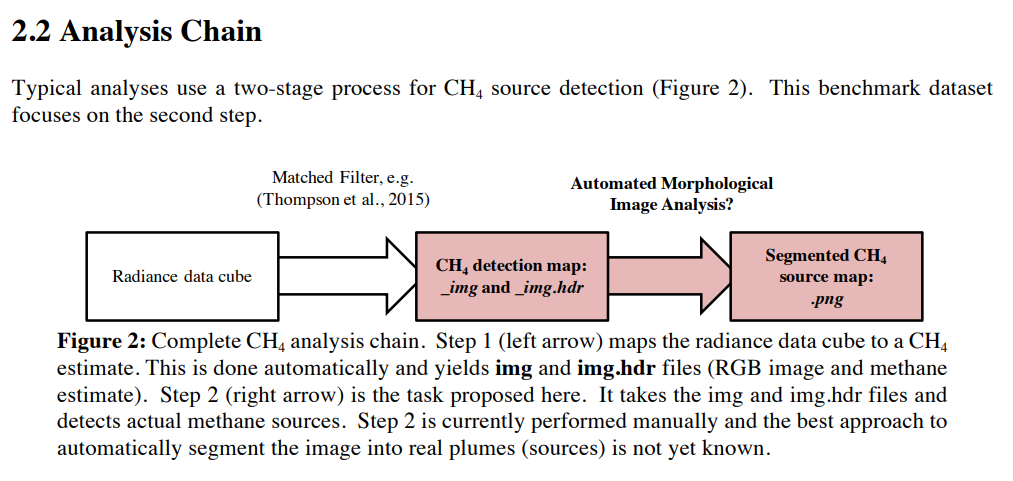


5. Compare to bottom up approach. Which is more reliable?

### Proposed Methodology:

1. Understanding the Problem Statement
    - Quantify methane emissions
    - Detection of methane in images
    - Detect source type


2. Exploratory Data Analysis
    - 


3. Feature Engineering


4. Data Modeling
    - Regression
    - CNN cloud computing?
    


5. Deployment 


### Things to do:

1. Presentation

2. What method?


### Related Literature:

1. https://github.com/satish1901/Methane-detection-from-hyperspectral-imagery

2. https://daac.ornl.gov/CMS/guides/CH4_Plume_AVIRIS-NG.html

3. https://blueraster.maps.arcgis.com/apps/MapSeries/index.html?appid=62b948e1b8ac48a7ace2ebfc3593ab84
